In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import sem
from sklearn import metrics
import pandas as pd
target_names = ['non-patient', 'patient']

In [2]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import sem, t

def eval_std_ci(truth_df, hyps_df):
    evs_scores = []
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    fold_indices = [(0, 17), (17, 35), (35, 52), (52, 69), (69, 86)]

    for start, end in fold_indices:
        truth = np.array(truth_df[start:end])
        hyps = np.array(hyps_df[start:end])
        # hyps_binary = (hyps >= 0.5).astype(int)

        evs = explained_variance_score(truth, hyps)
        evs_scores.append(evs)
        mae = mean_absolute_error(truth, hyps)
        mae_scores.append(mae)
        mse = mean_squared_error(truth, hyps)
        mse_scores.append(mse)
        rmse = np.sqrt(mean_squared_error(truth, hyps))
        rmse_scores.append(rmse)
        r2 = r2_score(truth, hyps)
        r2_scores.append(r2)

    mean_evs = np.mean(evs_scores)
    std_evs = np.std(evs_scores)
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    conf_interval_evs = t.interval(0.95, len(evs_scores)-1, loc=mean_evs, scale=std_evs/np.sqrt(len(evs_scores)))
    conf_interval_mae = t.interval(0.95, len(mae_scores)-1, loc=mean_mae, scale=std_mae/np.sqrt(len(mae_scores)))
    conf_interval_mse = t.interval(0.95, len(mse_scores)-1, loc=mean_mse, scale=std_mse/np.sqrt(len(mse_scores)))
    conf_interval_rmse = t.interval(0.95, len(rmse_scores)-1, loc=mean_rmse, scale=std_rmse/np.sqrt(len(rmse_scores)))
    conf_interval_r2 = t.interval(0.95, len(r2_scores)-1, loc=mean_r2, scale=std_r2/np.sqrt(len(r2_scores)))

    def adjust_confidence_interval(conf_interval):
        return (max(0, min(conf_interval[0], 1)), max(0, min(conf_interval[1], 1)))

    conf_interval_evs = adjust_confidence_interval(conf_interval_evs)
    conf_interval_mae = adjust_confidence_interval(conf_interval_mae)
    conf_interval_mse = adjust_confidence_interval(conf_interval_mse)
    conf_interval_rmse = adjust_confidence_interval(conf_interval_rmse)
    conf_interval_r2 = adjust_confidence_interval(conf_interval_r2)

    return evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
    mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
    std_evs, std_mae, std_mse, std_rmse, std_r2, \
    conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2

In [3]:
fivefolds_label = pd.read_csv('data/biclass2.txt', sep=' ')
fivefolds_label.rename(columns = {'file':'name'}, inplace = True)
fivefolds_label['name'] =  fivefolds_label['name'].str.replace('CTT', '').astype(int)
fivefolds_label['label'] =  fivefolds_label['label'].astype(bool).astype(str)
fivefolds_label['label'] =  fivefolds_label['label'].str.replace('False', 'Non-Dementia')
fivefolds_label['label'] =  fivefolds_label['label'].str.replace('True', 'Dementia')

## CDR

In [4]:
fivefolds_CDR = pd.read_csv('CDR_result/combine_v2_15k.csv')
# fivefolds_CDR['name'] =  fivefolds_CDR['name'].str.split('\\').str.get(-1).str.split('.wav').str.get(0).str.replace('CTT', '').astype(int)
fivefolds_CDR['name'] =  fivefolds_CDR['name'].astype(int)
fivefolds_CDR = fivefolds_CDR.sort_values(by=['name'])
fivefolds_CDR = fivefolds_CDR.reset_index(drop=True)
fivefolds_CDR['label'] = fivefolds_label['label']
fivefolds_CDR['Predicted CDR'] = fivefolds_CDR['hyps']
fivefolds_CDR['Truth CDR'] = fivefolds_CDR['truth']

In [5]:
fivefolds_CDR_label = fivefolds_CDR['label'].tolist()
fivefolds_CDR_hyps = [float(i) for i in fivefolds_CDR['hyps'].tolist()]
fivefolds_CDR_truth = [float(i) for i in fivefolds_CDR['truth'].tolist()]
fivefolds_CDR_name = [str(i).replace("CTT", "") for i in fivefolds_CDR['name'].tolist()]

In [6]:

print('mae: ', metrics.mean_absolute_error(fivefolds_CDR_truth, fivefolds_CDR_hyps))
print('mse: ', metrics.mean_squared_error(fivefolds_CDR_truth, fivefolds_CDR_hyps))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_CDR_truth, fivefolds_CDR_hyps)))
print('r2: ', metrics.r2_score(fivefolds_CDR_truth, fivefolds_CDR_hyps))
print('evs: ', metrics.explained_variance_score(fivefolds_CDR_truth, fivefolds_CDR_hyps))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_CDR_truth, fivefolds_CDR_hyps)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  0.2163101004133391
mse:  0.0978140361698306
rmse:  0.3127523559780655
r2:  0.06774148001022262
evs:  0.08310396879569393
EVS Scores: [0.13523406017564388, 0.12529791141291846, -0.6519069959725021, -0.4768053957471341, 0.0], MAE Scores: [0.2722807561649996, 0.19466369681888157, 0.3345501163207433, 0.15017889472929866, 0.13115035589126975], MSE Scores: [0.23262596708609629, 0.049594184029953844, 0.15040672121694007, 0.0339892953551329, 0.025290475051610833], RMSE Scores: [0.4823131421453248, 0.2226975168922048, 0.3878230540039363, 0.18436185981686368, 0.15902979296852157], R2 Scores: [0.09759859747809618, 0.10730468746083077, -0.6718285550652183, -1.4557265894083518, 0.0]
Mean MAE Scores: 0.2165647639850386, Std Dev: 0.07642928318418726, 95% Confidence Interval: (0.12166527464671274, 0.31146425332336447)
Mean MSE Scores: 0.09838132854794679, Std Dev: 0.08074287179974239, 95% Confidence Interval: (0, 0.19863684557326908)
Mean RMSE Scores: 0.28724507316537023, Std Dev: 0.125982524542

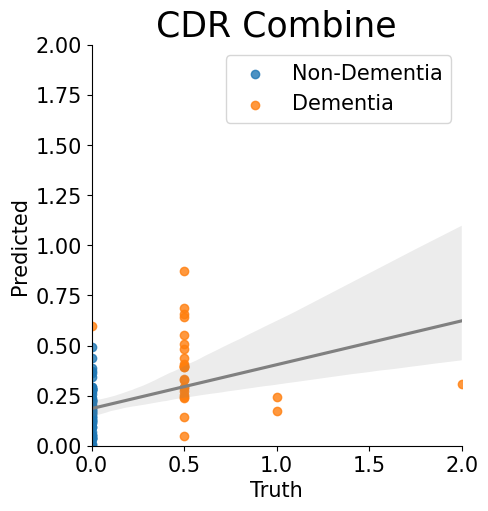

In [7]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

parameters = {'axes.labelsize': 25,
              'axes.titlesize': 30,
              'legend.fontsize': 15,
              'xtick.labelsize': 15,
              'ytick.labelsize': 15}
plt.rcParams.update(parameters)

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(fivefolds_CDR['truth'],fivefolds_CDR['hyps'])

# Use lmplot to plot scatter points
sns.lmplot(x='truth', y='hyps', hue='label', data=fivefolds_CDR, fit_reg=False, legend=False)

# Use regplot to plot the regression line and use line_kws to set line label for legend
# ax = sns.regplot(x="truth", y="hyps", data=fivefolds_14k, scatter_kws={"zorder":-1},
# line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), "color": "green"})
ax_CDR = sns.regplot(x="Truth CDR", y="Predicted CDR", data=fivefolds_CDR, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

# plot legend
ax_CDR.set_title("CDR Combine", fontsize=25)
ax_CDR.set_xlabel("Truth",fontsize=15)
ax_CDR.set_ylabel("Predicted",fontsize=15)
ax_CDR.set_xlim(0, 2)
ax_CDR.set_ylim(0, 2)
l1 = ax_CDR.legend()

# # save the plot as PNG file
plt.savefig("result_CDR.png")
plt.savefig("result_CDR.jpg")

## CDRSOB

In [8]:
fivefolds_CDRSOB = pd.read_csv('CDRSOB_result/combine_v2_15k.csv')
# fivefolds_CDRSOB['name'] =  fivefolds_CDRSOB['name'].str.split('\\').str.get(-1).str.split('.wav').str.get(0).str.replace('CTT', '').astype(int)
fivefolds_CDRSOB['name'] =  fivefolds_CDRSOB['name'].astype(int)
fivefolds_CDRSOB = fivefolds_CDRSOB.sort_values(by=['name'])
fivefolds_CDRSOB = fivefolds_CDRSOB.reset_index(drop=True)
fivefolds_CDRSOB['label'] = fivefolds_label['label']
fivefolds_CDRSOB['Predicted CDR-SOB'] = fivefolds_CDRSOB['hyps']
fivefolds_CDRSOB['Truth CDR-SOB'] = fivefolds_CDRSOB['truth']

In [9]:
fivefolds_CDRSOB_label = fivefolds_CDRSOB['label'].tolist()
fivefolds_CDRSOB_hyps = [float(i) for i in fivefolds_CDRSOB['hyps'].tolist()]
fivefolds_CDRSOB_truth = [float(i) for i in fivefolds_CDRSOB['truth'].tolist()]
fivefolds_CDRSOB_name = [str(i).replace("CTT", "") for i in fivefolds_CDRSOB['name'].tolist()]

In [10]:

print('mae: ', metrics.mean_absolute_error(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps))
print('mse: ', metrics.mean_squared_error(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps)))
print('r2: ', metrics.r2_score(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps))
print('evs: ', metrics.explained_variance_score(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_CDRSOB_truth, fivefolds_CDRSOB_hyps)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  0.6975208401570425
mse:  1.773190551543026
rmse:  1.331612012390631
r2:  0.13181975841843507
evs:  0.14689842608401982
EVS Scores: [0.1153371317841887, 0.09151616464297807, -0.07707435712397692, 0.0, 0.0], MAE Scores: [1.2259895457502674, 0.8487918852931924, 0.8910685121355688, 0.26566706362235193, 0.21904315077699715], MSE Scores: [5.67638476155841, 1.1327546924279412, 1.7664285092252143, 0.14031330236053138, 0.08865379212522746], RMSE Scores: [2.382516476660426, 1.0643094909038167, 1.3290705433592358, 0.37458417259747023, 0.2977478667013879], R2 Scores: [0.032738681550483206, -0.057672969298711685, -0.08964319992761349, 0.0, 0.0]
Mean MAE Scores: 0.6901120315156756, Std Dev: 0.38853234988365865, 95% Confidence Interval: (0.2076854005276273, 1)
Mean MSE Scores: 1.7609070115394647, Std Dev: 2.056615016667286, 95% Confidence Interval: (0, 1)
Mean RMSE Scores: 1.0896457100444672, Std Dev: 0.7573501423523691, 95% Confidence Interval: (0.14927130425103285, 1)
Mean R2: -0.022915497535

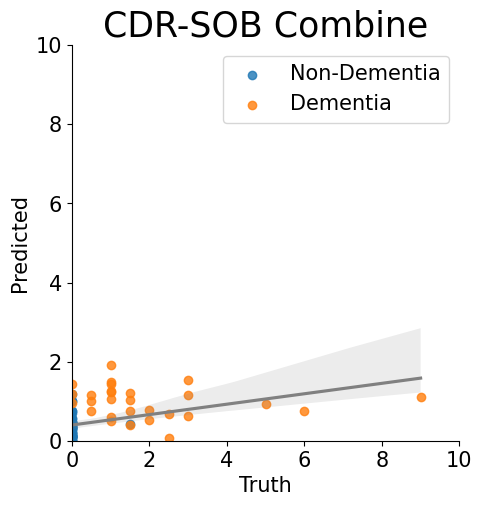

In [11]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(fivefolds_CDRSOB['truth'],fivefolds_CDRSOB['hyps'])

# Use lmplot to plot scatter points
sns.lmplot(x='truth', y='hyps', hue='label', data=fivefolds_CDRSOB, fit_reg=False, legend=False)

# Use regplot to plot the regression line and use line_kws to set line label for legend
# ax = sns.regplot(x="truth", y="hyps", data=fivefolds_14k, scatter_kws={"zorder":-1},
# line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), "color": "green"})
ax_CDRSOB = sns.regplot(x="Truth CDR-SOB", y="Predicted CDR-SOB", data=fivefolds_CDRSOB, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

# plot legend
ax_CDRSOB.set_title("CDR-SOB Combine", fontsize=25)
ax_CDRSOB.set_xlabel("Truth",fontsize=15)
ax_CDRSOB.set_ylabel("Predicted",fontsize=15)
ax_CDRSOB.set_xlim(0, 10)
ax_CDRSOB.set_ylim(0, 10)
l2 = ax_CDRSOB.legend()

# # save the plot as PNG file
plt.savefig("result_CDRSOB.png")
plt.savefig("result_CDRSOB.jpg")

## MMSE

In [12]:
fivefolds_MMSE = pd.read_csv('MMSE_result/combine_v2_15k.csv')
# fivefolds_MMSE['name'] =  fivefolds_MMSE['name'].str.split('\\').str.get(-1).str.split('.wav').str.get(0).str.replace('CTT', '').astype(int)
fivefolds_MMSE['name'] =  fivefolds_MMSE['name'].astype(int)
fivefolds_MMSE = fivefolds_MMSE.sort_values(by=['name'])
fivefolds_MMSE = fivefolds_MMSE.reset_index(drop=True)
fivefolds_MMSE['label'] = fivefolds_label['label']
fivefolds_MMSE['Predicted MMSE'] = fivefolds_MMSE['hyps']
fivefolds_MMSE['Truth MMSE'] = fivefolds_MMSE['truth']

In [13]:
fivefolds_MMSE_label = fivefolds_MMSE['label'].tolist()
fivefolds_MMSE_hyps = [float(i) for i in fivefolds_MMSE['hyps'].tolist()]
fivefolds_MMSE_truth = [float(i) for i in fivefolds_MMSE['truth'].tolist()]
fivefolds_MMSE_name = [str(i).replace("CTT", "") for i in fivefolds_MMSE['name'].tolist()]

In [14]:

print('mae: ', metrics.mean_absolute_error(fivefolds_MMSE_truth, fivefolds_MMSE_hyps))
print('mse: ', metrics.mean_squared_error(fivefolds_MMSE_truth, fivefolds_MMSE_hyps))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_MMSE_truth, fivefolds_MMSE_hyps)))
print('r2: ', metrics.r2_score(fivefolds_MMSE_truth, fivefolds_MMSE_hyps))
print('evs: ', metrics.explained_variance_score(fivefolds_MMSE_truth, fivefolds_MMSE_hyps))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_MMSE_truth, fivefolds_MMSE_hyps)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")

print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  2.994801431543687
mse:  22.751180301537566
rmse:  4.769819734700418
r2:  0.24339361086179967
evs:  0.2526842278027669
EVS Scores: [0.16985644351605966, 0.2126421100218845, 0.19879807972850705, 0.0, 0.0], MAE Scores: [4.539851413053624, 3.7507475217183432, 3.895535300759708, 1.4522390926585484, 1.1846892237663265], MSE Scores: [49.23680414618292, 30.63599622453325, 25.849109527666286, 4.087427321028909, 2.278474792260395], RMSE Scores: [7.016894195168039, 5.53497933370426, 5.084201955830068, 2.0217386876223418, 1.509461755812447], R2 Scores: [0.03738084168266376, 0.09639847275841817, 0.19151594659138993, 0.0, 0.0]
Mean MAE Scores: 2.96461251039131, Std Dev: 1.3726910329026534, 95% Confidence Interval: (1, 1)
Mean MSE Scores: 22.41756240233435, Std Dev: 17.550878039251284, 95% Confidence Interval: (0.6252690041309208, 1)
Mean RMSE Scores: 4.233455185627431, Std Dev: 2.1202404565564175, 95% Confidence Interval: (1, 1)
Mean R2: 0.06505905220649437, Std Dev: 0.0723946811634932, 95% Co

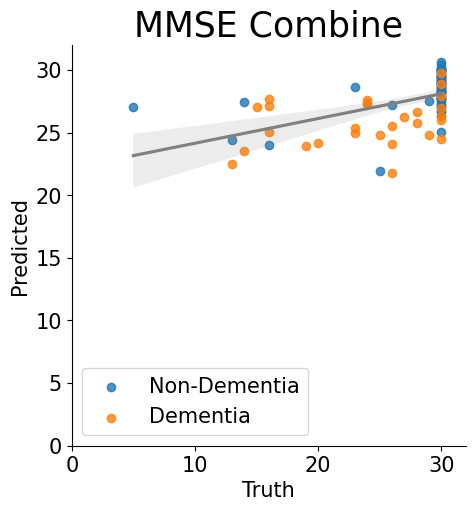

In [15]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(fivefolds_MMSE['truth'],fivefolds_MMSE['hyps'])

# Use lmplot to plot scatter points
sns.lmplot(x='truth', y='hyps', hue='label', data=fivefolds_MMSE, fit_reg=False, legend=False)

# Use regplot to plot the regression line and use line_kws to set line label for legend
# ax = sns.regplot(x="truth", y="hyps", data=fivefolds_14k, scatter_kws={"zorder":-1},
# line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), "color": "green"})
ax_MMSE = sns.regplot(x="Truth MMSE", y="Predicted MMSE", data=fivefolds_MMSE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

# plot legend
ax_MMSE.set_title("MMSE Combine", fontsize=25)
ax_MMSE.set_xlabel("Truth",fontsize=15)
ax_MMSE.set_ylabel("Predicted",fontsize=15)
ax_MMSE.set_xlim(0, 32)
ax_MMSE.set_ylim(0, 32)
l3 = ax_MMSE.legend()

# # save the plot as PNG file
plt.savefig("result_MMSE.png")
plt.savefig("result_MMSE.jpg")